In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.analysis.tis_analysis import TISTransition
from openpathsampling.analysis.tis_analysis import sampleset_sample_generator

storage = paths.storage.Storage("_toy_retis.nc", mode="r")

In [2]:
print len(storage.samplesets)

10001


In [3]:
retis = storage.transitions.load(0)

In [4]:
%%time
retis.move_summary(storage)
print

pathreversal ran 25.6574342566% of the cycles with acceptance 2185/2566 (0.851519875292) 
shooting ran 49.0250974903% of the cycles with acceptance 3650/4903 (0.744442178258) 
minus ran 1.4898510149% of the cycles with acceptance 149/149 (1.0) 
repex ran 23.8176182382% of the cycles with acceptance 714/2382 (0.299748110831) 

CPU times: user 3min 26s, sys: 18.7 s, total: 3min 45s
Wall time: 3min 59s


In [5]:
%%time
retis.move_summary(storage, 'shooting')
print

OneWayShootingMover I'face 1 ran 7.99920007999% of the cycles with acceptance 649/800 (0.81125) 
OneWayShootingMover I'face 2 ran 8.01919808019% of the cycles with acceptance 606/802 (0.755610972569) 
OneWayShootingMover I'face 3 ran 8.12918708129% of the cycles with acceptance 600/813 (0.738007380074) 
OneWayShootingMover I'face 4 ran 8.13918608139% of the cycles with acceptance 527/814 (0.64742014742) 
OneWayShootingMover I'face 0 ran 8.21917808219% of the cycles with acceptance 713/822 (0.867396593674) 
OneWayShootingMover I'face 5 ran 8.51914808519% of the cycles with acceptance 555/852 (0.651408450704) 

CPU times: user 602 µs, sys: 100 µs, total: 702 µs
Wall time: 485 µs


In [6]:
def first_n(storage, n, trajid):
    sample_iter = sampleset_sample_generator(storage)
    first = []
    old=None
    for s in sample_iter:
        if s.replica == trajid:
            if s != old:
                first.append(s)
            old = s
        if len(first) == n:
            break
    return first

In [7]:
first40 = first_n(storage, 40, trajid=4)

In [8]:
%%time
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

tree = PathTreeBuilder(storage)        
tree.rejected = True
tree.from_samples(first40)
view = tree.renderer
view.zoom = 0.8
view.scale_y = 24
view.scale_x = 14
view.font_size = 0.35

CPU times: user 1.99 s, sys: 165 ms, total: 2.15 s
Wall time: 2.53 s


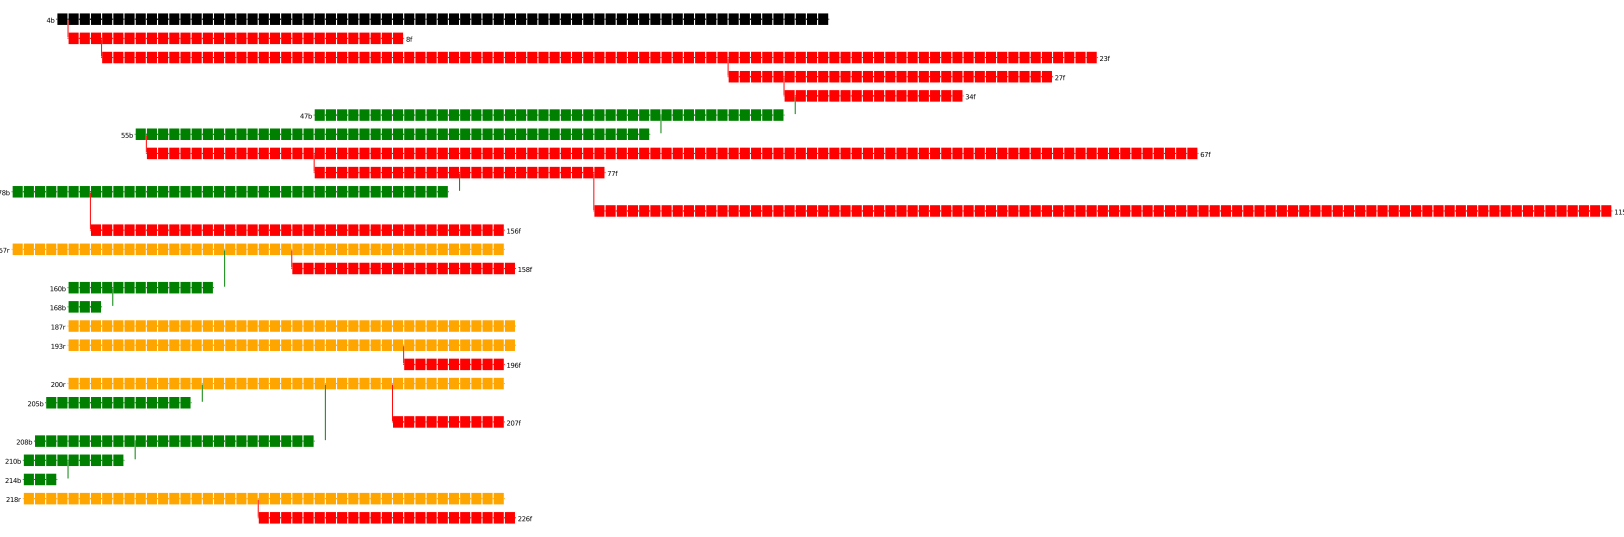

In [9]:
SVG(view.to_svg())

In [10]:
prev = first40[0].trajectory
decorrelated = [prev]
for s in first40:
    if not paths.Trajectory.is_correlated(s.trajectory, prev):
        decorrelated.append(s.trajectory)
        prev = s.trajectory
print "From these samples we have " + str(len(decorrelated)) + " decorrelated trajectories."

From these samples we have 5 decorrelated trajectories.


In [11]:
retis.ensemble_histogram_info['pathlength'].hist_args = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.ensemble_histogram_info['max_lambda'].hist_args = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [12]:
%%time
retis.all_statistics(storage=storage, weights=None, force=True)

CPU times: user 6min 24s, sys: 31.2 s, total: 6min 55s
Wall time: 7min 19s


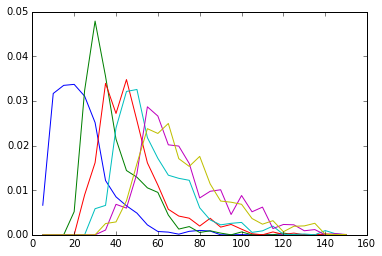

In [13]:
for ens in retis.ensembles:
    myhist = retis.histograms['pathlength'][ens]
    plt.plot(myhist.plot_bins(), myhist.normalized())

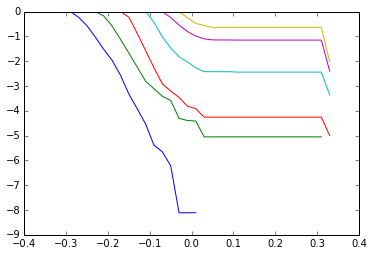

In [14]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), 
             np.log(myhist.reverse_cumulative())
            )

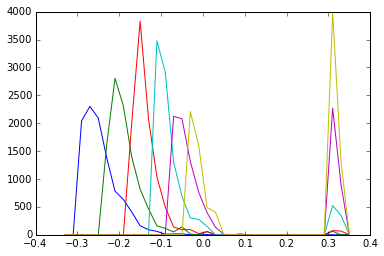

In [15]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), myhist())

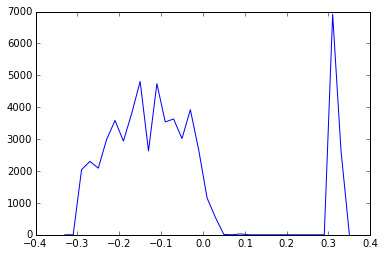

In [16]:
# TODO: add a histogram.sum_hist() function to add several histograms together
from operator import add
total_sampling = np.zeros(len(retis.histograms['max_lambda'][retis.ensembles[0]]()))
for ens in retis.ensembles:
    total_sampling = map(add, total_sampling, retis.histograms['max_lambda'][ens]())
plt.plot(myhist.plot_bins(), total_sampling);

In [17]:
from toy_plot_helpers import ToyPlot
plot = ToyPlot()
plot.add_pes(storage.engines.load(0).pes)

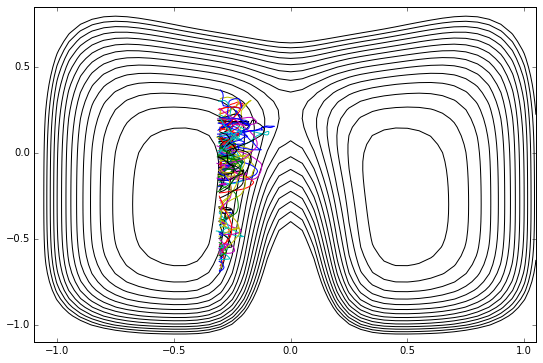

In [18]:
ens0_traj = [s.trajectory for s in storage.samples if s.ensemble == retis.ensembles[0]]
plt.contour(plot.X, plot.Y, plot._pes, levels=np.arange(0.0, 1.5, 0.1), colors='k')
for mytraj in ens0_traj[slice(None,None,15)]:
    plt.plot(mytraj.coordinates()[:,0,0], mytraj.coordinates()[:,0,1])

In [19]:
wham = retis.total_crossing_probability(method="wham")

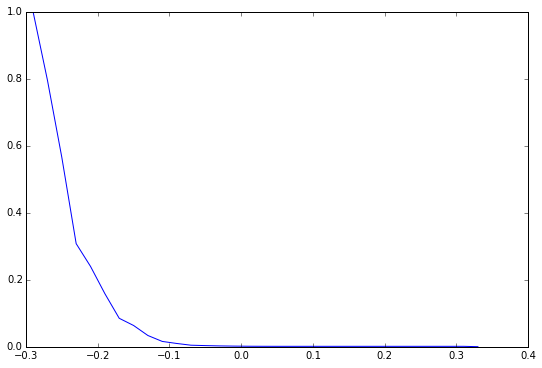

In [20]:
plt.plot(wham.keys(), wham.values());

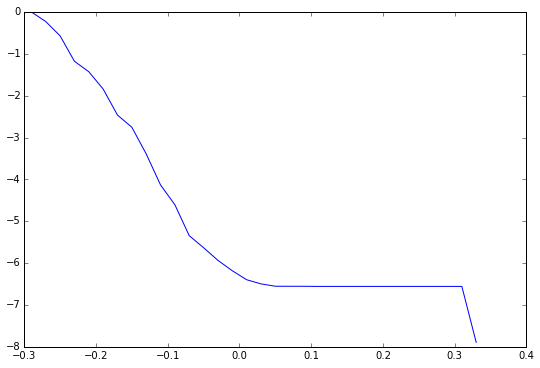

In [21]:
plt.plot(wham.keys(), np.log(wham.values()));

In [22]:
%%time
#retis.rate(storage=storage)
# TODO: conditional_transition_probability, minus_flux, rate
retis.conditional_transition_probability(storage, retis.ensembles[-1])

CPU times: user 7.33 s, sys: 538 ms, total: 7.87 s
Wall time: 7.87 s


0.5301469853014699

In [23]:
print retis._flux, retis.tcp(-0.05), retis.ctp[retis.ensembles[-1]]

None 0.00358153127752 0.530146985301


In [41]:
%%time
#logging.getLogger("openpathsampling.ensemble").debug("test")

from openpathsampling.analysis.tis_analysis import summarize_trajectory
flux_outside_ensemble = paths.AllOutXEnsemble(retis.minus_ensemble.innermost_vol)
flux_inside_ensemble = paths.AllInXEnsemble(retis.minus_ensemble.innermost_vol)
minus = retis.movers['minus'][0]
out_lengths = []
in_lengths = []
for delta in storage.pathmovechanges:
    if minus in delta and delta.accepted:
        # assume only one minus ensemble sample
        minus_trajectory = [s.trajectory for s in delta.samples if s.ensemble==minus.minus_ensemble][0]
        out_lengths.extend(map(len, flux_outside_ensemble.split(minus_trajectory)))
        in_lengths.extend(map(len, flux_inside_ensemble.split(minus_trajectory)[1:-1]))
        break

delta = my_minus
print out_lengths
print in_lengths


[19, 22]
[966]
CPU times: user 13.9 s, sys: 1.27 s, total: 15.1 s
Wall time: 15.1 s


In [42]:
print minus.minus_ensemble.i

[
{x[t] in {x|xval(x) in [-inf, -0.3]} for all t} (SINGLE FRAME),
{(
  x[t] in (not {x|xval(x) in [-inf, -0.3]}) for all t
)
and
(
  x[t] in {x|xval(x) in [-inf, -0.3]} for all t
)} (OPTIONAL),
(
  x[t] in (not {x|xval(x) in [-inf, -0.3]}) for all t
)
and
(
  exists t such that x[t] in (not {x|xval(x) in [-inf, -0.3]})
),
x[t] in {x|xval(x) in [-inf, -0.3]} for all t,
(
  x[t] in (not {x|xval(x) in [-inf, -0.3]}) for all t
)
and
(
  exists t such that x[t] in (not {x|xval(x) in [-inf, -0.3]})
),
{(
  x[t] in (not {x|xval(x) in [-inf, -0.3]}) for all t
)
and
(
  x[t] in {x|xval(x) in [-inf, -0.3]} for all t
)} (OPTIONAL),
{x[t] in {x|xval(x) in [-inf, -0.3]} for all t} (SINGLE FRAME)
]
